In [333]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import glob
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import randint
from datetime import datetime

pd.options.mode.chained_assignment = None # default='warn'

# 1. Data

This data has been derived from the sunshine and radiation `kis_tos_202403.gz` dataset from [KNMI][1], which has measurements of average solar irradiance (_Q_) and sunshine duration (_SQ_) for 10 minute intervals for the whole month of March 2024. The data from the original dataset was preprocessed and saved. The preprocessing included removing night values to enhance the performance of the prediction process since only useful data is fed to the model [(Alzahrani _et al._ 2017)][2].

[1]: https://dataplatform.knmi.nl/dataset/zonneschijnduur-en-straling-1-0
[2]: https://www.sciencedirect.com/science/article/pii/S1877050917318392

This LSTM is trained on data from one specific weather station, given that otherwise we would have multiple data points of the same variable at the same timestamp. The code below shows how was the csv file constructed from the dataframe that was got from KNMI website. The same code for getting the usable dataset could be used on any other weather station from the same original big dataset with multiple weather stations over one month (given that there are no missing values). In case there are null values present in the data that is wished to be trained on, the imputation should be done by interpolation, imputation methods, distance function, artificial neural network, or nonlinear regression methods [(Zhao and Huang 2015)][3].

[3]: https://onlinelibrary.wiley.com/doi/10.1155/2015/260580

**Why not use Moving Averages?**

ARMA and ARIMA models are widely used in solar radiation predictions, however, machine learning techniques often result in better predictions [(Attar _et al._ 2023)][4]. This is also due to the fact that solar irradiance is highly influenced by air temperature, cloud cover, surface reflectivity, and aerosols. Findings also support that there is high correlation with temperature, relative humidity, wind speed, and sunshine duration.

[4]: https://link.springer.com/article/10.1007/s10098-022-02434-7

## 1.1 First dataset

The dataset features only one weather station (_Location_), as otherwise there would be multiple measurements for same time stamps. 

In [417]:
# This function reads the data from the .gz files and returns a pandas dataframe
def gz_to_df(file_names):
    dataframes = []
    for file_name in file_names:
        with gzip.open(file_name, 'rt') as file:
            df = pd.read_csv(file, comment='#', sep='\\s\\s+', engine='python', header=None, names=['Time', 'Location', 'Name', 'Latitude', 'Longitude', 'Altitude', 'Q_GLOB_10', 'QN_GLOB_10', 'QX_GLOB_10', 'SQ_10'], index_col='Time', parse_dates=True)
            df = df.dropna()
            dataframes.append(df)
    solar_data = pd.concat(dataframes)
    return solar_data

# Load and preprocess data
file_names = glob.glob('kis_tos_*.gz') 
solar_data = gz_to_df(file_names)

# Here I have selected only the first weather station of the whole dataset,
# but you can modify it, run the whole notebook once again, and therefore train the model on a different weather station
solar_data = solar_data[solar_data['Location'] == solar_data['Location'].unique()[0]]
solar_data.head()

,Location,Name,Latitude,Longitude,Altitude,Q_GLOB_10,QN_GLOB_10,QX_GLOB_10,SQ_10
Time,,,,,,,,,
2024-03-01 00:10:00,215_S_a,Voorschoten stralingsmeter,52.139722,4.436389,-1.1,0.0,0.0,0.0,0.0
2024-03-01 00:20:00,215_S_a,Voorschoten stralingsmeter,52.139722,4.436389,-1.1,0.0,0.0,0.0,0.0
2024-03-01 00:30:00,215_S_a,Voorschoten stralingsmeter,52.139722,4.436389,-1.1,0.0,0.0,0.0,0.0
2024-03-01 00:40:00,215_S_a,Voorschoten stralingsmeter,52.139722,4.436389,-1.1,0.0,0.0,0.0,0.0
2024-03-01 00:50:00,215_S_a,Voorschoten stralingsmeter,52.139722,4.436389,-1.1,0.0,0.0,0.0,0.0


In [418]:

data_solar = solar_data[['Q_GLOB_10', 'SQ_10']]
data_solar[['Q', 'SQ']] = solar_data[['Q_GLOB_10', 'SQ_10']].apply(pd.to_numeric, errors='coerce') # Convert to numeric and replace errors with NaN
data_solar.drop(columns=['Q_GLOB_10', 'SQ_10'], inplace=True) # Drop original columns
data_solar = data_solar.dropna() # Drop rows with NaN values after conversion

data_solar['Hour'] = data_solar.index.hour
data_solar['DayOfWeek'] = data_solar.index.dayofweek
data_solar['Month'] = data_solar.index.month
data_solar['DayOfYear'] = data_solar.index.dayofyear

data_solar.head()

,Q,SQ,Hour,DayOfWeek,Month,DayOfYear
Time,,,,,,
2024-03-01 00:10:00,0.0,0.0,0,4,3,61
2024-03-01 00:20:00,0.0,0.0,0,4,3,61
2024-03-01 00:30:00,0.0,0.0,0,4,3,61
2024-03-01 00:40:00,0.0,0.0,0,4,3,61
2024-03-01 00:50:00,0.0,0.0,0,4,3,61


Above you can see how the initial preprocessing was done for the first dataset. Below you can see, how it was saved to a csv file.

In [419]:
data_solar.to_csv('data_solar.csv')

You do not need to run any of the code above in this section, as the downloaded csv file is already in the GitHub repository.

In [437]:
# Load the data
data_path = 'data_solar.csv'
df1 = pd.read_csv(data_path)
df1

,Time,Q,SQ,Hour,DayOfWeek,Month,DayOfYear
0,2024-03-01 00:10:00,0.0,0.0,0,4,3,61
1,2024-03-01 00:20:00,0.0,0.0,0,4,3,61
2,2024-03-01 00:30:00,0.0,0.0,0,4,3,61
3,2024-03-01 00:40:00,0.0,0.0,0,4,3,61
4,2024-03-01 00:50:00,0.0,0.0,0,4,3,61
...,...,...,...,...,...,...,...
4458,2024-03-31 23:20:00,0.0,0.0,23,6,3,91
4459,2024-03-31 23:30:00,0.0,0.0,23,6,3,91
4460,2024-03-31 23:40:00,0.0,0.0,23,6,3,91
4461,2024-03-31 23:50:00,0.0,0.0,23,6,3,91


In [438]:
# Extract relevant columns (drop the month, as this is only being trained on one month)
hours = df1['Hour'].values
days = df1['DayOfYear'].values
solar_irradiance = df1['Q'].values

# Remove night hours (consider only 5 AM to 6 PM),
# but this might be different depending on the location and time of the year
day_hours = (hours >= 5) & (hours <= 18)
hours_day = hours[day_hours]
days_day = days[day_hours]
solar_irradiance_day = solar_irradiance[day_hours]


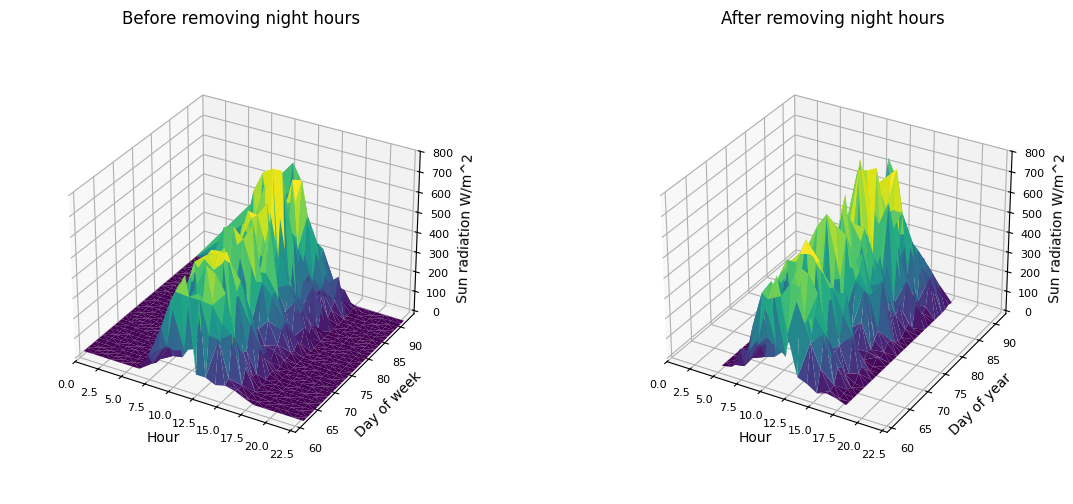

In [440]:
# Create 3D plots
fig = plt.figure(figsize=(14, 6))

# Set the same limits for both plots
xlim = (hours.min(), hours.max())

# Before removing night hours
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(hours, days, solar_irradiance, cmap='viridis')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Day of week')
ax1.set_zlabel('Sun radiation W/m^2')
ax1.set_title('Before removing night hours')
ax1.set_xlim(xlim)
ax1.set_box_aspect(None, zoom=0.85)

# Make ax2 ticks font size smaller
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.tick_params(axis='z', which='major', labelsize=8)

# After removing night hours
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(hours_day, days_day, solar_irradiance_day, cmap='viridis')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Day of year')
ax2.set_zlabel('Sun radiation W/m^2')
ax2.set_title('After removing night hours')
ax2.set_xlim(xlim)
ax2.set_box_aspect(None, zoom=0.85) # To make the z-axis label visible

# Make ax2 ticks font size smaller
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.tick_params(axis='z', which='major', labelsize=8)

plt.show()


Removing irradiance data during night hours improves the performance of the prediction model
by ensuring that only relevant and useful data is used to train the neural network.
This practice helps in focusing the model's learning on periods where solar irradiance is present,
leading to more accurate and reliable predictions [(Alzahrani _et al._ 2017)][5].

[5]: https://www.sciencedirect.com/science/article/pii/S1877050917318392



In [441]:
df1['Hour'] = df1['Hour'].astype(int)
df1 = df1[(df1['Hour'] >= 5) & (df1['Hour'] <= 18)]
df1

,Time,Q,SQ,Hour,DayOfWeek,Month,DayOfYear
29,2024-03-01 05:00:00,0.0,0.0,5,4,3,61
30,2024-03-01 05:10:00,0.0,0.0,5,4,3,61
31,2024-03-01 05:20:00,0.0,0.0,5,4,3,61
32,2024-03-01 05:30:00,0.0,0.0,5,4,3,61
33,2024-03-01 05:40:00,0.0,0.0,5,4,3,61
...,...,...,...,...,...,...,...
4427,2024-03-31 18:10:00,2.0,0.0,18,6,3,91
4428,2024-03-31 18:20:00,0.0,0.0,18,6,3,91
4429,2024-03-31 18:30:00,0.0,0.0,18,6,3,91
4430,2024-03-31 18:40:00,0.0,0.0,18,6,3,91


## 1.2 Second dataset

The second dataset is from the [KNMI daily weather data archive][5] for March 2024. 

[5]: https://www.knmi.nl/nederland-nu/klimatologie/daggegevens

In [399]:
data_all_path = "/Users/liischmidt/Desktop/MOVEMENT/Finn/vorigemaand.txt" # Path to the file with the data description

# Since the original file is very big, I uploaded the data_all.csv processed file to the repository

# Define a function to process each line of the file,
# so it shows only the english translation of the description
def process_line(line):
    match = re.match(r'^(.*?=).*?/\s+(.*)$', line)
    if match:
        part_before = match.group(1)
        part_after = match.group(2)
        cleaned_line = f"{part_before} {part_after}"
        return cleaned_line
    return line

# Read and process the file description
with open(data_all_path, "r") as file:
    for i, line in enumerate(file):
        line = line.strip()
        cleaned_line = process_line(line)
        print(cleaned_line)
        if i == 25:
            break



YYYYMMDD  = date (YYYY=year,MM=month,DD=day)
HH        = time (HH uur/hour, UT. 12 UT=13 MET, 14 MEZT. Hourly division 05 runs from 04.00 UT to 5.00 UT
DD        = Mean wind direction (in degrees) during the 10-minute period preceding the time of observation (360=north, 90=east, 180=south, 270=west, 0=calm 990=variable)
FH        = Hourly mean wind speed (in 0.1 m/s)
FF        = Mean wind speed (in 0.1 m/s) during the 10-minute period preceding the time of observation
FX        = Maximum wind gust (in 0.1 m/s) during the hourly division
T         = Temperature (in 0.1 degrees Celsius) at 1.50 m at the time of observation
T10N      = Minimum temperature (in 0.1 degrees Celsius) at 0.1 m in the preceding 6-hour period
TD        = Dew point temperature (in 0.1 degrees Celsius) at 1.50 m at the time of observation
SQ        = Sunshine duration (in 0.1 hour) during the hourly division, calculated from global radiation (-1 for <0.05 hour)
Q         = Global radiation (in J/cm2) during the h

In [400]:
# Read the file
data_all = pd.read_csv(data_all_path, sep=',', engine='python', skiprows = 27, on_bad_lines='skip')
data_all.columns = ['STN', 'YYYYMMDD', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'T10N', 'TD', 'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'WW', 'IX', 'M', 'R', 'S', 'O', 'Y']
data_all = data_all[data_all['STN'] == 215] # Select only the same weather station as in the first dataset
data_all

,STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10N,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
743,215,20240301,1,170,60,60,100,99,,82,...,70,8,89,,5,0,0,0,0,0
744,215,20240301,2,180,60,60,90,100,,82,...,70,8,88,,5,0,0,0,0,0
745,215,20240301,3,300,80,60,140,62,,51,...,63,8,93,57,7,0,1,0,0,0
746,215,20240301,4,270,50,40,90,64,,49,...,70,8,90,23,7,0,1,0,0,0
747,215,20240301,5,260,40,30,80,54,,45,...,65,5,93,22,7,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,215,20240331,20,70,30,30,60,104,,97,...,59,8,95,81,7,0,1,0,0,0
1483,215,20240331,21,110,30,30,50,105,,100,...,50,8,96,23,7,0,1,0,0,0
1484,215,20240331,22,120,20,20,80,99,,95,...,50,7,97,10,7,0,0,0,0,0
1485,215,20240331,23,150,30,30,40,93,,89,...,29,2,97,10,7,0,0,0,0,0


In [401]:
data_all = data_all.apply(pd.to_numeric, errors='coerce') # Convert to numeric and replace errors with NaN


In [402]:
unique_value_columns = [col for col in data_all.columns if data_all[col].nunique() == 1] # Find columns with only one unique value
data_all = data_all.drop(columns=unique_value_columns) # Drop columns with only one unique value


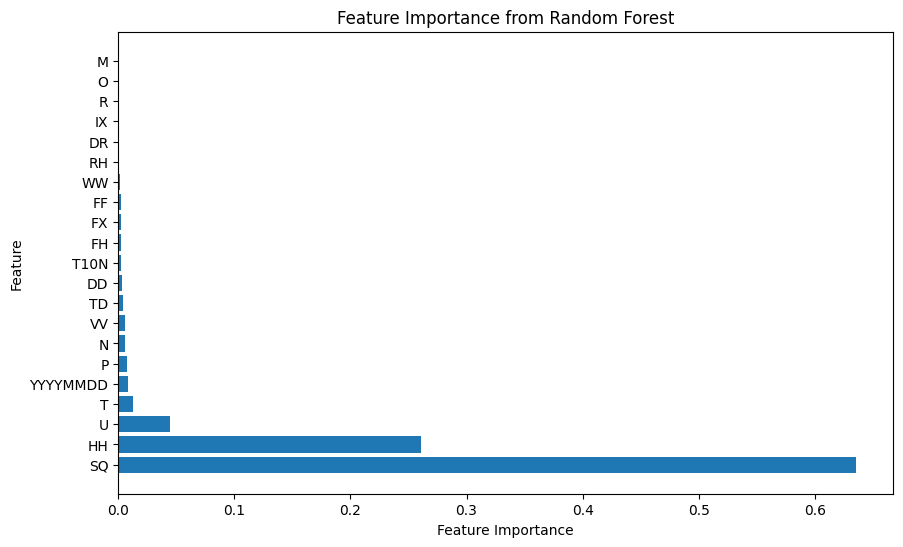

In [403]:
X = data_all.drop(columns=['Q'])
y = data_all['Q']

# Fit the model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.show()


Based on the feature importance plot from the Random Forest model, it's clear that sunshine duration (_SQ_) and time of day (_HH_) are the most influential features for forecasting solar irradiance (_Q_). This makes intuitive sense, as solar irradiance is directly related to the amount of sunshine received, which is captured by _SQ_. _HH_ is also crucial since solar irradiance follows a daily pattern. These two features should definitely be retained in the model due to their high importance scores and clear relevance to the target variable.

Additionally, relative atmospheric humidity (_U_) has a moderate importance score. Relative humidity can affect solar irradiance by influencing cloud formation and atmospheric opacity, which in turn affects the amount of solar radiation reaching the surface. Although its importance is less than _SQ_ and _HH_, it is still significant enough to be considered for inclusion in the model. Including temperatue (_T_) can also be beneficial, as temperature is often correlated with solar irradiance, particularly in clear sky conditions where higher temperatures usually coincide with higher irradiance levels. 

The features with very low importance scores, such as date (_YYYYMMDD_), air pressure (_P_), cloud cover (_N_), and various wind-related features (_DD_, _FF_, _FH_, _FX_), can be dropped. While these features might have some indirect effects on solar irradiance, their low importance scores indicate that they do not contribute significantly to the predictive power of the model.

By focusing on the most relevant features, the model can be simplified without sacrificing accuracy. This not only reduces computational complexity but also helps in preventing overfitting, ensuring the model generalizes better to unseen data. Thus, based on both the feature importance scores and supporting literature, the features _SQ_, _HH_, _U_, and _T_ should be retained, while the remaining less important features can be dropped.

In case you find the literature or any other points to be more relevant or overweigh the feature importance scores, you can always modify the same model to include more features. Also, _YYYYMMDD_ could potentially be more influential, if data given to it covers more than one month. Hence, the above feature importance checking code should be re-ran for bigger datasets.

In [404]:
data_all = data_all[['SQ', 'Q', 'HH', 'U', 'T', 'YYYYMMDD']]
data_all['YYYYMMDD'] = pd.to_datetime(data_all['YYYYMMDD'], format='%Y%m%d') # Convert to datetime
data_all



,SQ,Q,HH,U,T,YYYYMMDD
743,0,0,1,89,99,2024-03-01
744,0,0,2,88,100,2024-03-01
745,0,0,3,93,62,2024-03-01
746,0,0,4,90,64,2024-03-01
747,0,0,5,93,54,2024-03-01
...,...,...,...,...,...,...
1482,0,0,20,95,104,2024-03-31
1483,0,0,21,96,105,2024-03-31
1484,0,0,22,97,99,2024-03-31
1485,0,0,23,97,93,2024-03-31


In [405]:
data_all.to_csv('data_all.csv', index=False)

In [406]:
df2 = pd.read_csv('data_all.csv') # This file is already processed and uploaded to the repository

In [407]:
# Extract relevant columns (drop the month, as this is only being trained on one month)
hours = df2['HH'].values
df2['DayOfYear'] = pd.to_datetime(df2['YYYYMMDD']).dt.dayofyear
days = df2['DayOfYear'].values
solar_irradiance = df2['Q'].values

# Remove night hours (consider only 5 AM to 6 PM),
# but this might be different depending on the location and time of the year
day_hours = (hours >= 5) & (hours <= 18)
hours_day = hours[day_hours]
days_day = days[day_hours]
solar_irradiance_day = solar_irradiance[day_hours]


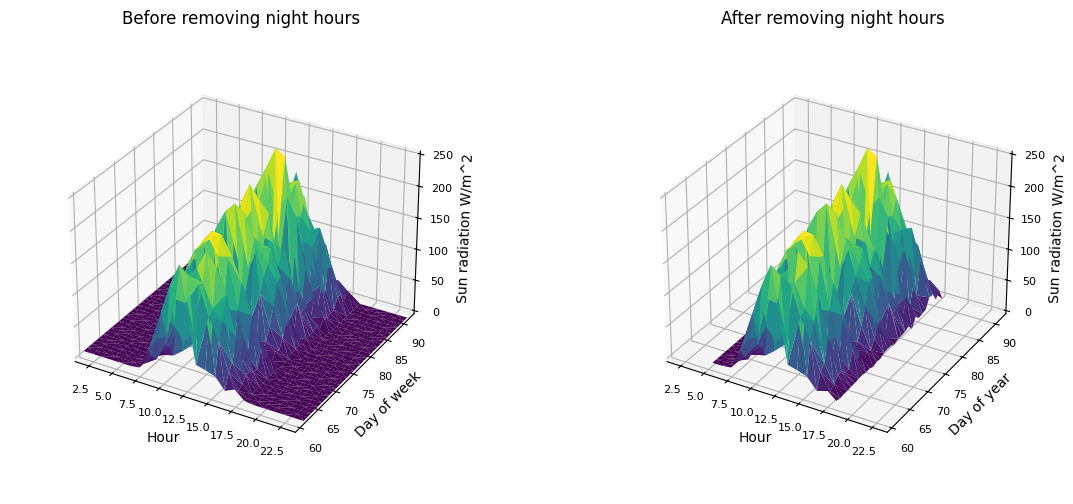

In [408]:
# Create 3D plots
fig = plt.figure(figsize=(14, 6))

# Set the same limits for both plots
xlim = (hours.min(), hours.max())

# Before removing night hours
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(hours, days, solar_irradiance, cmap='viridis')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Day of week')
ax1.set_zlabel('Sun radiation W/m^2')
ax1.set_title('Before removing night hours')
ax1.set_xlim(xlim)
ax1.set_box_aspect(None, zoom=0.85)

# Make ax2 ticks font size smaller
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.tick_params(axis='z', which='major', labelsize=8)

# After removing night hours
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(hours_day, days_day, solar_irradiance_day, cmap='viridis')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Day of year')
ax2.set_zlabel('Sun radiation W/m^2')
ax2.set_title('After removing night hours')
ax2.set_xlim(xlim)
ax2.set_box_aspect(None, zoom=0.85) # To make the z-axis label visible

# Make ax2 ticks font size smaller
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.tick_params(axis='z', which='major', labelsize=8)

plt.show()

# 2. Models

The models that were selected were LSTM and CNN-LSTM, as LSTM is suitable for time-series data, whereas CNN-LSTM combines convolutional layers for feature extraction and LSTM layers for sequence prediction. The layout of the notebook is the data and then the models.

In [442]:
# Ensure to use all available cores
torch.set_num_threads(torch.get_num_threads())

In [443]:
# Check if a GPU is available and set the device to GPU if it is,
# otherwise default to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [444]:
df2 = df2[['Q', 'SQ', 'HH', 'U', 'T', 'DayOfYear']] # In case you want to train and run the model on the second dataset

## 2.1 First dataset models

In [445]:
df1['Time'] = pd.to_datetime(df1['Time'])
df1.set_index('Time', inplace=True)

In [446]:
# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df1)

### 2.1.1 LSTM

In [447]:
# Function to create sequences
def create_sequences(data, input_length):
    xs, ys = [], []
    for i in range(len(data) - input_length):
        x = data[i:i+input_length]
        y = data[i+input_length, 0] # Assumes that the target variable is the first column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_length = 24 * 6 # 24 hours of data with 10-minute intervals
hidden_size = 100
num_layers = 2
num_epochs = 50
learning_rate = 0.001
batch_size = 64

In [448]:
# Create sequences
X, y = create_sequences(data_scaled, input_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [449]:
# Define the model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Since there was not enough processing power to do hyperparameter tuning iteratively with grid search, I chose the hyperparameters myself. These values below should set a good balance between model complexity and training efficiency. A hidden size of 64 is large enough to capture complex patterns in the data but not so large that it becomes computationally prohibitive. Two layers are often sufficient to model time series data without overfitting. Fifty epochs provide enough iterations for the model to learn effectively without excessive training time. A learning rate of 0.001 is a standard starting point that often works well with Adam optimizer, and a batch size of 32 balances training speed and stability.

The model is trained for a specified number of epochs, minimizing the mean squared error loss using the Adam optimizer. Training progress is printed every 10 epochs.

In [450]:
# Instantiate the model, define loss function and optimizer
model1_1 = LSTMModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers)
model1_1 = model1_1.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1_1.parameters(), lr=learning_rate)

In [451]:
# Train the model
for epoch in range(num_epochs):
    model1_1.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model1_1(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.0255
Epoch [20/50], Loss: 0.0835
Epoch [30/50], Loss: 0.1202
Epoch [40/50], Loss: 0.0461
Epoch [50/50], Loss: 0.1767


Through hyperparameter tuning, the performance of the model should significantly increase. However, it was not feasible here, as there is not enough processing power.

In [452]:
# Save the model
torch.save(model1_1.state_dict(), 'lstm_model_1.pth')
print('Model saved as lstm_model_1.pth')

Model saved as lstm_model_1.pth


In [455]:
# Generate rolling predictions by iteratively feeding the last input_length data points 
# and predicting the next point, updating the sequence each time
def rolling_predictions(model, data, input_length, output_length):
    model.eval()
    predictions = []
    current_seq = data[-input_length:, :]  # Start with the last input_length data points

    for _ in range(output_length):
        current_seq_tensor = torch.tensor(current_seq, dtype=torch.float32).unsqueeze(0).to(device)
        pred = model(current_seq_tensor)
        pred = pred.detach().cpu().numpy().flatten()
        predictions.append(pred)

        # Update the sequence
        next_seq = np.vstack((current_seq[1:], np.append(pred, np.zeros(current_seq.shape[1]-1))))
        current_seq = next_seq

    return np.array(predictions).flatten()

In [457]:
# Predict the next 12 data points
output_length = 12
preds = rolling_predictions(model1_1, data_scaled, input_length, output_length)

# Inverse scaling to match the true data
preds_rescaled = scaler.inverse_transform(np.hstack([preds.reshape(-1, 1)] * df1.shape[1]))[:, 0]

# Calculate residuals on the training set for standard deviation
model1_1.eval()
train_preds = model1_1(X_train.to(device))
train_residuals = y_train.numpy() - train_preds.cpu().detach().numpy().flatten()
std_dev = np.std(train_residuals)

# Calculate prediction intervals
pred_intervals = np.vstack([preds_rescaled - std_dev, preds_rescaled + std_dev]).T

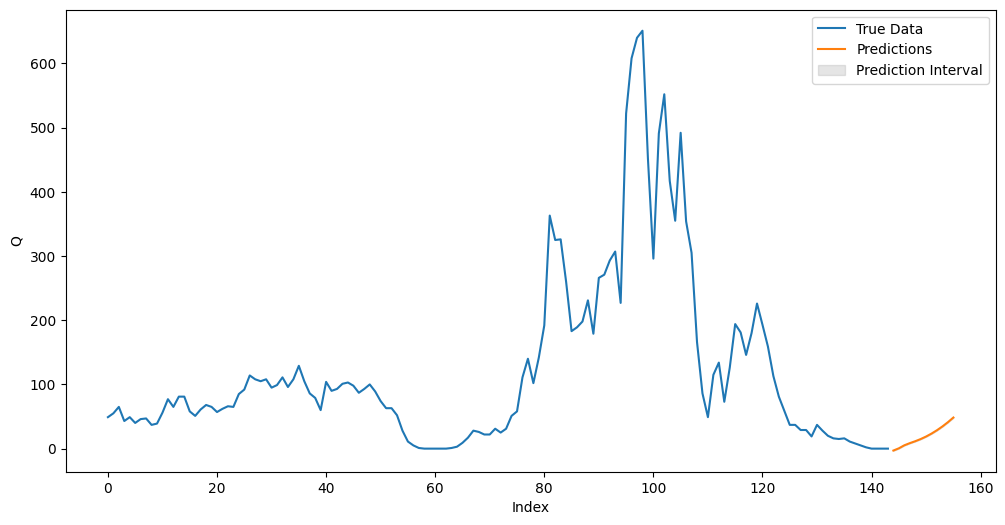

In [472]:
# Use the last input_length hours from the actual data for true data
input_data = scaler.inverse_transform(data_scaled[-input_length:])[:, 0]
prediction_hours = [5 + (i * 10 / 60) for i in range(output_length)]  # Generate hours for the predictions

plt.figure(figsize=(12, 6))
plt.plot(range(len(input_data)), input_data, label='True Data')  # Use range to keep indexing simple
plt.plot(range(len(input_data), len(input_data) + len(preds_rescaled)), preds_rescaled, label='Predictions')
plt.fill_between(range(len(input_data), len(input_data) + len(preds_rescaled)), 
                 pred_intervals[:, 0], pred_intervals[:, 1], color='gray', alpha=0.2, label='Prediction Interval')
plt.xlabel('Index')  # You can modify it to be datetime, but since we dropped the night hours, it would need to be adjusted
plt.ylabel('Q')
plt.legend()
plt.show()

### 2.1.2 CNN-LSTM

In [473]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(CNNLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define CNN layers
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # Calculate the size of the input for LSTM after CNN layers
        self.lstm_input_size = 32 * (input_length // 4)  # Ensure this matches your CNN output shape
        
        # Define LSTM layers
        self.lstm = nn.LSTM(self.lstm_input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the final fully connected layer
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Apply CNN layers
        x = x.permute(0, 2, 1)  # Change the shape to [batch_size, input_size, input_length]
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten the output for LSTM
        
        # Apply LSTM layers
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        x = x.unsqueeze(1)  # Add a sequence dimension [batch_size, 1, lstm_input_size]
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [475]:
# Instantiate the model, criterion, and optimizer
model1_2 = CNNLSTMModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers)
model1_2 = model1_2.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1_2.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    model1_2.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size].to(device)
        y_batch = y_train[i:i + batch_size].to(device)
        
        outputs = model1_2(X_batch)
        optimizer.zero_grad()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/Users/liischmidt/opt/anaconda3/envs/liis_new_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/liischmidt/opt/anaconda3/envs/liis_new_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([47])) that is different to the input size (torch.Size([47, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/50], Loss: 0.8082
Epoch [20/50], Loss: 0.8045
Epoch [30/50], Loss: 0.7931
Epoch [40/50], Loss: 0.7803
Epoch [50/50], Loss: 0.7779


In [476]:
torch.save(model1_2.state_dict(), 'model1_2.pth')
print('Model saved as model1_2.pth')

Model saved as model1_2.pth


/var/folders/tm/zl0819cd6rxg09d85h_bv0380000gn/T/ipykernel_42105/2545028940.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start=df1.index[-1], periods=output_length, freq='10T')


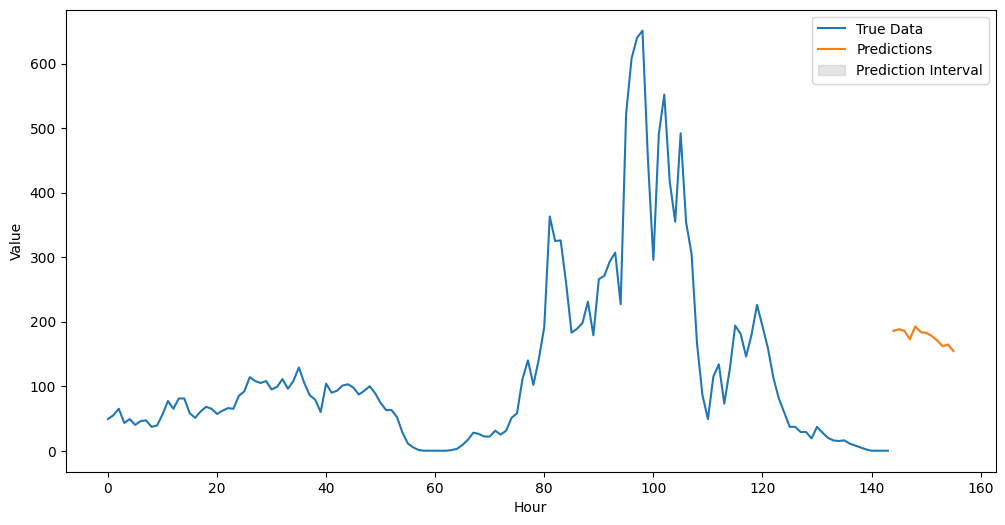

In [480]:
# Predict the next 12 data points
preds = rolling_predictions(model1_2, data_scaled, input_length, output_length)
preds = preds.flatten()

# Inverse scaling to match the true data
preds_rescaled = scaler.inverse_transform(np.hstack([preds.reshape(-1, 1)] * df1.shape[1]))[:, 0]

# Calculate residuals on the training set
model1_2.eval()
train_preds = model1_2(X_train.to(device))
train_preds = train_preds.detach().cpu().numpy().flatten()
train_residuals = y_train.numpy().flatten() - train_preds

# Calculate the standard deviation of the residuals
std_dev = np.std(train_residuals)

# Calculate prediction intervals
pred_intervals = np.vstack([preds_rescaled - std_dev, preds_rescaled + std_dev]).T

# Plot
input_data = scaler.inverse_transform(data_scaled[-input_length:])[:, 0]
date_range = pd.date_range(start=df1.index[-1], periods=output_length, freq='10T')

plt.figure(figsize=(12, 6))
plt.plot(range(len(input_data)), input_data, label='True Data')
plt.plot(range(len(input_data), len(input_data) + len(preds_rescaled)), preds_rescaled, label='Predictions')
plt.fill_between(range(len(input_data), len(input_data) + len(preds_rescaled)),
                 pred_intervals[:, 0], pred_intervals[:, 1], color='gray', alpha=0.2, label='Prediction Interval')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend()
plt.show()

## 2.3 Extra

In [481]:
data = df1

The following code can be run, but it is too processing heavy right now. However, here are two other examples of how the models could be modified:

To improve the performance of the LSTM model, you can perform hyperparameter tuning. By adjusting the hyperparameters, such as hidden size, number of layers, learning rate, and batch size, you can find the optimal configuration for your specific dataset. This can be done using techniques like grid search or random search.

Another way to enhance the model is by adding more convolutional layers to the CNN-LSTM model. By increasing the depth and complexity of the convolutional layers, the model can capture more intricate patterns and features in the input data. This can potentially improve the model's ability to make accurate predictions.

Please note that both of these modifications may require additional computational resources and time for training. It is recommended to run them on a machine with sufficient processing power or consider using cloud-based services for faster execution.


In [482]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.values)

def create_sequences(data, input_length, output_length):
    xs, ys = [], []
    for i in range(len(data) - input_length - output_length + 1):
        x = data[i:i+input_length]
        y = data[i+input_length:i+input_length+output_length]
        xs.append(x)
        ys.append(y[:, 0])
    return xs, ys

input_length = 24 * 6  # 24 hours of data with 10-minute intervals
output_length = 1  # Predicting one point at a time
hidden_size = 100 # Number of memory cells in one LSTM layer
num_layers = 3 # Number of LSTM layers
num_epochs = 100
learning_rate = 0.001

X, y = create_sequences(data_scaled, input_length, output_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_padded = pad_sequence([torch.tensor(x, dtype=torch.float32) for x in X_train], batch_first=True)
y_train_padded = pad_sequence([torch.tensor(y, dtype=torch.float32) for y in y_train], batch_first=True)
X_test_padded = pad_sequence([torch.tensor(x, dtype=torch.float32) for x in X_test], batch_first=True)
y_test_padded = pad_sequence([torch.tensor(y, dtype=torch.float32) for y in y_test], batch_first=True)
train_lengths = torch.tensor([len(x) for x in X_train], dtype=torch.int64)
test_lengths = torch.tensor([len(x) for x in X_test], dtype=torch.int64)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size # Number of memory cells in one LSTM layer
        self.num_layers = num_layers # Number of LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, lengths):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input, (h0, c0))
        out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        out = self.fc(out[range(len(out)), lengths-1])
        return out
    
model = LSTMModel(input_size=X_train_padded.shape[2], hidden_size=hidden_size, num_layers=num_layers, output_size=output_length)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_padded.to(device), train_lengths)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_padded.to(device))
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def rolling_predictions(model, data, input_length, output_points):
    model.eval()
    predictions = []
    current_seq = data[-input_length:, :]  # Initialize with the last input_length data points

    for _ in range(output_points):
        current_seq_tensor = torch.tensor(current_seq, dtype=torch.float32).unsqueeze(0).to(device)
        current_length = torch.tensor([len(current_seq)], dtype=torch.int64).cpu()
        pred = model(current_seq_tensor, current_length)
        pred = pred.detach().cpu().numpy().flatten()
        predictions.append(pred)

        next_seq = np.vstack((current_seq[1:], np.tile(pred, (current_seq.shape[1], 1)).T))
        current_seq = next_seq

    return np.array(predictions)

preds = rolling_predictions(model, data_scaled, input_length=input_length, output_points=12)
preds = preds.flatten()
preds_rescaled = scaler.inverse_transform(np.hstack([preds.reshape(-1, 1)] * data.shape[1]))[:, 0]
# Calculate residuals on the training set
model.eval()
train_preds = model(X_train_padded.to(device), train_lengths)
train_preds = train_preds.detach().cpu().numpy().flatten()
train_residuals = y_train_padded.numpy().flatten() - train_preds

# Calculate the standard deviation of the residuals
std_dev = np.std(train_residuals)

# Calculate prediction intervals
pred_intervals = np.vstack([preds_rescaled - std_dev, preds_rescaled + std_dev]).T
plt.figure(figsize=(12, 6))
plt.plot(range(len(data_scaled)), scaler.inverse_transform(data_scaled)[:, 0], label='True Data')
plt.plot(range(len(data_scaled), len(data_scaled) + len(preds_rescaled)), preds_rescaled, label='Predictions')
plt.fill_between(range(len(data_scaled), len(data_scaled) + len(preds_rescaled)), 
                 pred_intervals[:, 0], pred_intervals[:, 1], color='gray', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.show()

In [ ]:
# Function to create sequences
def create_sequences(data, input_length, output_length):
    xs, ys = [], []
    for i in range(len(data) - input_length - output_length):
        x = data[i:i+input_length]
        y = data[i+input_length:i+input_length+output_length]
        xs.append(x)
        ys.append(y[:, 0])  # Ensure target shape is correct
    return np.array(xs), np.array(ys)

# Parameters
input_length = 24  # Example, can loop over input_lengths for different lengths
output_length = 12  # Predicting next 2 hours
hidden_size = 100
num_layers = 4
num_epochs = 60
learning_rate = 0.001

# Create sequences
X, y = create_sequences(data_scaled, input_length, output_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(2)  # Ensuring correct shape
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(2)  # Ensuring correct shape

# Adjust the target shape
y_train = y_train.squeeze(2)
y_test = y_test.squeeze(2)

# Define model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Ensure output size matches target size
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model, define loss function and optimizer
model = LSTMModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers, output_size=output_length)
model = model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Modified rolling predictions function
def rolling_predictions(model, data, input_length, output_length):
    model.eval()
    predictions = []
    current_seq = data[-input_length:, :]  # Initialize with the last input_length data points, keep all features

    for _ in range(output_length):
        current_seq_tensor = torch.tensor(current_seq, dtype=torch.float32).unsqueeze(0)
        pred = model(current_seq_tensor)
        pred = pred.detach().cpu().numpy().flatten()
        predictions.append(pred)

        # Update current_seq by removing the first row and appending the prediction at the end
        # Ensure dimensions match correctly
        pred_extended = np.tile(pred, (current_seq.shape[1], 1)).T
        next_seq = np.vstack((current_seq[1:], pred_extended))
        current_seq = next_seq

    return np.array(predictions)

# Make rolling predictions for the next 2 hours
preds = rolling_predictions(model, data_scaled, input_length, output_length)
preds = preds.flatten()  # Ensure predictions are a flat array

# Inverse scaling to match the true data
preds_rescaled = scaler.inverse_transform(np.hstack([preds.reshape(-1, 1)] * data.shape[1]))[:, 0]
preds_rescaled[preds_rescaled < -1] = -1
preds_rescaled

# Dummy prediction intervals (standard deviation), replace with actual calculation if available
std_dev = 0.1  # Example value, calculate based on model residuals if needed
pred_intervals = np.vstack([preds_rescaled - std_dev, preds_rescaled + std_dev]).T

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(data_scaled)), scaler.inverse_transform(data_scaled)[:, 0], label='True Data')  # Plot only the first column
plt.plot(range(len(data_scaled), len(data_scaled) + len(preds_rescaled)), preds_rescaled, label='Predictions')
plt.fill_between(range(len(data_scaled), len(data_scaled) + len(preds_rescaled)), 
                 pred_intervals[:, 0], pred_intervals[:, 1], color='gray', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.show()

# 3. Further Refinements

To make the training and model more efficient, algorithm based feature selection could be used. 

Additionally, due to limitations in processing and time efficiency, here, only one month was used to train the model. However, to make the model more generalizable, it could be trained on a whole year worth of data, from the same location as it is being used at.

Furthermore, iterative feature selection could be useful for utilizing the second dataset.

Hyperparameter tuning is crucial for optimizing the performance of machine learning models. It involves selecting the best set of hyperparameters that minimize the loss function and improve the model's generalization ability. Techniques like Grid Search and Randomized Search are commonly used to explore different hyperparameter combinations. Grid Search exhaustively searches through a predefined set of hyperparameters, while Randomized Search samples a subset of the hyperparameter space, often leading to faster results with fewer evaluations.

Limitations and Constraints
In this study, detailed hyperparameter tuning was not feasible due to computational constraints. The extensive nature of Grid Search or Randomized Search would require significant processing power and time, which were limited. Instead, hyperparameters were selected based on domain knowledge and prior research, aiming to balance model complexity and performance. Future work could focus on leveraging more advanced tuning techniques and larger computational resources to refine the model further.

Publicly available alternative models for solar irradiance forecasting (that were tested and working) are following:
- Time Series Forecasting of Solar Irradiance by [Gautam][a].
- Solar Irradiance Forecasting with Transformer Model by [Kubovčik][b_1], and the respective research paper by [Pospichal _et al._ 2022][b_2].
- Irradiance RNN by [DiMaggio][c], based on the paper by [Alzahrani _et al._ 2017][c_2]. 
- Solar Prediction by [Wang][d].

[a]: https://github.com/sgautam666/Time_Series_Forecasting_of_Solar_Irradiance
[b_1]: https://github.com/markub3327/Solar-Transformer
[b_2]: https://www.mdpi.com/2076-3417/12/17/8852
[c_1]: https://github.com/antoninodimaggio/Irradiance-RNN
[c_2]: https://www.sciencedirect.com/science/article/pii/S1877050917318392
[d]: https://github.com/Kejie-Wang/SolarPrediction